# CS422 Project Report - Amit Nikam

___
## Table on Content:
1. Overview
2. Abstract
3. Data Processing
4. Data Analysis (exploratory Data analysis)
5. Data Visualizattion
6. model training and selection
7. Conclusion 
8. Bibliography /References

___
## Abstract

One of my main findings from this project was that the data is often bias and doing any operation on the data would not generate any outcome. Specifically, I learned that data could be majorly from one class making the data from other classes less valuable. We need to pay special attention to normalizing our data else it is extremely easy to overfit a model. I also learned how to research, read, and understand the documentation of Python tools/packages, along with installing packages in some cases. Another research finding was understanding the importance of making not only different models, but also tuning models that will generate better outcomes. Working on a large dataset for the first time revealed that brute force methods can be implemented only if we reduce the dimensions and features of our data.

## Overview

Problem statement: The objective of this project is to build a model that generalizes well out of sample.

Relevant literature: See References

Proposed methodology: First we start by data overview and analysis. Once we have got an idea of the data, we will try to reduce the dimension and features, which will give us advantage while training models. Then we will select which model to use for our data and then finally build a pipeline. Last part would be to save this pipeline through Onnx.

## Solution

###### Installs

In [1]:
!pip install xgboost
!pip install skl2onnx
!pip install onnxruntime
!pip install graphviz
!pip install sklearn_pandas
!pip install sklearn2pmml
!pip install pydot
!pip install onnxmltools


###### Imports

In [71]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns

### Models
import xgboost as xgb
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
###

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn_pandas import DataFrameMapper

from sklearn.pipeline import Pipeline
from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline 
from sklearn2pmml.decoration import ContinuousDomain
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_regression, SelectFromModel

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn
import onnxruntime as rt 
from onnx.tools.net_drawer import GetPydotGraph,GetOpNodeProducer 
from onnxmltools.convert.common.shape_calculator import calculate_linear_classifier_output_shapes

###### Reading in the data

In [3]:
df=pd.read_csv('./data/data_public.csv.gz',compression='gzip',quotechar='"',na_values='?')
df.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
0,231.420023,-12.210984,217.624839,-15.611916,140.047185,76.904999,131.591871,198.160805,82.873279,127.350084,224.592926,-5.992983,-14.689648,143.072058,153.439659,2
1,-38.019270,-14.195695,9.583547,22.293822,-25.578283,-18.373955,-0.094457,-33.711852,-8.356041,23.792402,4.199023,2.809159,-59.330681,-11.685950,1.317104,3
2,-39.197085,-20.418850,21.023083,19.790280,-25.902587,-19.189004,-2.953836,-25.299219,-6.612401,26.285392,5.911292,6.191587,-56.924996,-4.675187,-1.027830,2
3,221.630408,-5.785352,216.725322,-9.900781,126.795177,85.122288,108.857593,197.640135,82.560019,157.105143,212.989231,-3.621070,-15.469156,135.265859,149.212489,2
4,228.558412,-12.447710,204.637218,-13.277704,138.930529,91.101870,115.598954,209.300011,89.961688,130.299732,201.795100,-1.573922,-15.128603,148.368622,147.492663,3


##### Splitter -> function that splits DataFrame into train and test data

In [4]:
def splitter(df):
    columns = list(df.columns[:-1])
    X = df[columns]
    y = pd.DataFrame(data=df['Class'],columns=['Class'])
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    return (X_train, X_test, y_train, y_test)

___
### Data Processing and Analysis

###### Checking for Value types and Missing Values

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 16 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   A       1200000 non-null  float64
 1   B       1200000 non-null  float64
 2   C       1200000 non-null  float64
 3   D       1200000 non-null  float64
 4   E       1200000 non-null  float64
 5   F       1200000 non-null  float64
 6   G       1200000 non-null  float64
 7   H       1200000 non-null  float64
 8   I       1200000 non-null  float64
 9   J       1200000 non-null  float64
 10  K       1200000 non-null  float64
 11  L       1200000 non-null  float64
 12  M       1200000 non-null  float64
 13  N       1200000 non-null  float64
 14  O       1200000 non-null  float64
 15  Class   1200000 non-null  int64  
dtypes: float64(15), int64(1)
memory usage: 146.5 MB


In [6]:
df.describe()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
count,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06
mean,5.068656e+01,-1.883373e+01,7.162152e+01,-1.355120e+01,2.944177e+01,-6.185189e+00,3.174186e+01,5.112504e+01,3.300077e+01,4.092546e+01,7.938340e+01,-6.746540e+00,-4.232290e+01,4.949012e+01,5.980333e+01,2.167323e+00
std,1.292492e+02,1.446355e+01,1.052808e+02,4.689774e+01,7.282278e+01,7.309100e+01,6.660329e+01,1.034053e+02,4.217119e+01,7.694386e+01,9.484003e+01,1.557490e+01,1.791142e+01,6.728231e+01,6.677712e+01,6.874930e-01
min,-7.308940e+01,-8.322357e+01,-5.972853e+01,-1.375818e+02,-3.829826e+01,-1.485917e+02,-6.654137e+01,-4.246089e+01,-1.818542e+01,-1.123844e+02,-1.415233e+01,-6.271828e+01,-8.144988e+01,-2.057979e+01,-1.283059e+01,1.000000e+00
25%,-3.793679e+01,-1.786669e+01,7.553164e+00,-1.471337e+01,-2.436286e+01,-3.072492e+01,-3.484185e+00,-2.629661e+01,-7.594991e+00,2.108044e+01,2.419273e+00,-8.875128e+00,-5.567326e+01,-7.131906e+00,1.628438e-01,2.000000e+00
50%,-3.197847e+01,-1.369876e+01,1.348796e+01,-8.004308e+00,-1.897058e+01,-2.475391e+01,1.491431e+00,-1.817028e+01,3.769369e+01,2.717432e+01,2.652955e+01,-1.079123e+00,-5.297585e+01,1.462293e+01,4.689262e+01,2.000000e+00
75%,2.280020e+02,-1.055606e+01,2.123439e+02,1.955806e+01,1.289018e+02,7.834417e+01,1.151840e+02,1.915891e+02,7.984842e+01,1.253846e+02,2.046458e+02,3.334451e+00,-2.208504e+01,1.363603e+02,1.451293e+02,3.000000e+00
max,2.687738e+02,4.460108e+00,2.561698e+02,3.263799e+01,1.579843e+02,1.229186e+02,1.660534e+02,2.329496e+02,1.112970e+02,1.755397e+02,2.598003e+02,2.159496e+01,1.032828e+01,1.789303e+02,1.807011e+02,3.000000e+00


It is observed that there are no Null records. In total there are 1.2 Million records. There are a total of 15 features from A to O, followed by Class Labels.

##### Principal Component Analysis

The next piece of information we want to discover is the optimal number of principal components to use
throughout this project. To do this, we run a PCA with n_components set to the total number of features and
generated a scree plot (the code to generate this plot was found [here](https://districtdatalabs.silvrback.com/principal-component-analysis-with-python).

Before applying the PCA, the data is scaled.

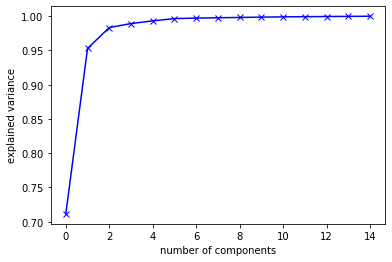

[7.11447169e-01 2.41423046e-01 3.05472040e-02 5.76603629e-03
 3.95249929e-03 3.35997122e-03 6.37710310e-04 5.44675407e-04
 4.57257234e-04 4.47617738e-04 3.71201367e-04 3.01512481e-04
 2.48754417e-04 1.94997777e-04 1.79105275e-04]

 [71.14471689 95.28702154 98.34174195 98.91834558 99.3135955  99.64959263
 99.71336366 99.7678312  99.81355692 99.8583187  99.89543883 99.92559008
 99.95046552 99.9699653  99.98787583]


In [7]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.drop('Class', axis=1)))
df_scaled = pd.concat([df_scaled,df['Class']],axis=1)

pca_all_comp = decomposition.PCA(n_components=15)
pca_all_comp.fit(df_scaled)

plt.plot(np.cumsum(pca_all_comp.explained_variance_ratio_),'bx-')
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.show()
print(pca_all_comp.explained_variance_ratio_)
print('\n',np.cumsum(pca_all_comp.explained_variance_ratio_ * 100))

From the Cumulative Explained Variance it can be observed that using just two principal components we can get upto 95% variance. Thus we will use two principal components where ever required in pipelines.

##### Check for Feature Correlation and redundant pairs

Here we try to find the correlation between the different features so as to understand which features can be dropped.

In [8]:
df.corr('pearson')

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
A,1.000000,0.455949,0.991999,0.071330,0.990703,0.905353,0.972223,0.988807,0.818399,0.870016,0.968827,0.139619,0.958931,0.953081,0.920322,-0.000620
B,0.455949,1.000000,0.541742,0.865856,0.352946,0.760708,0.620607,0.339549,-0.098558,0.803246,0.246429,0.854635,0.345030,0.194578,0.098805,0.000138
C,0.991999,0.541742,1.000000,0.176224,0.971805,0.943482,0.988351,0.968342,0.753474,0.915784,0.937868,0.238723,0.941040,0.916578,0.873800,-0.000686
D,0.071330,0.865856,0.176224,1.000000,-0.047459,0.477183,0.279248,-0.062451,-0.502643,0.544357,-0.163679,0.949485,-0.042057,-0.217856,-0.316241,0.000150
E,0.990703,0.352946,0.971805,-0.047459,1.000000,0.849129,0.939705,0.997116,0.879142,0.805749,0.989217,0.026319,0.964769,0.979925,0.958885,-0.000649
F,0.905353,0.760708,0.943482,0.477183,0.849129,1.000000,0.969055,0.841227,0.508345,0.989868,0.781534,0.518117,0.823551,0.745156,0.675416,-0.000540
G,0.972223,0.620607,0.988351,0.279248,0.939705,0.969055,1.000000,0.934714,0.678043,0.949429,0.894114,0.335039,0.910385,0.867546,0.815281,-0.000472
H,0.988807,0.339549,0.968342,-0.062451,0.997116,0.841227,0.934714,1.000000,0.886017,0.796856,0.990875,0.012005,0.964627,0.982403,0.962873,-0.000670
I,0.818399,-0.098558,0.753474,-0.502643,0.879142,0.508345,0.678043,0.886017,1.000000,0.439881,0.926217,-0.418110,0.848801,0.943365,0.970965,-0.000766
J,0.870016,0.803246,0.915784,0.544357,0.805749,0.989868,0.949429,0.796856,0.439881,1.000000,0.730841,0.579309,0.781815,0.691273,0.615931,-0.000333


Next we try to find the correlation pairs so that we can form groups and remove redundant elements. To do so, we use the following source code from stackoverflow. (https://stackoverflow.com/questions/17778394/list-highestcorrelation-pairs-from-a-large-correlation-matrix-in-pandas)

In [9]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 50))
print("\nRedundant Pairs")
print(get_redundant_pairs(df))

Top Absolute Correlations
E  H    0.997116
K  N    0.992158
A  C    0.991999
H  K    0.990875
A  E    0.990703
F  J    0.989868
E  K    0.989217
N  O    0.988920
A  H    0.988807
C  G    0.988351
K  O    0.982980
H  N    0.982403
E  N    0.979925
A  G    0.972223
C  E    0.971805
I  O    0.970965
F  G    0.969055
A  K    0.968827
C  H    0.968342
E  M    0.964769
H  M    0.964627
   O    0.962873
A  M    0.958931
E  O    0.958885
K  M    0.956598
A  N    0.953081
D  L    0.949485
G  J    0.949429
M  N    0.947381
C  F    0.943482
I  N    0.943365
C  M    0.941040
E  G    0.939705
C  K    0.937868
G  H    0.934714
M  O    0.926620
I  K    0.926217
A  O    0.920322
C  N    0.916578
   J    0.915784
G  M    0.910385
A  F    0.905353
G  K    0.894114
H  I    0.886017
E  I    0.879142
C  O    0.873800
A  J    0.870016
G  N    0.867546
B  D    0.865856
   L    0.854635
dtype: float64

Redundant Pairs
{('Class', 'E'), ('J', 'A'), ('K', 'C'), ('Class', 'L'), ('Class', 'H'), ('M', 'F'), ('F', '

This analysis shows a strong correlation between most of the features making most of their pairs redundant. We further explore the correlation and similarity between the all features visually. 
Although this doesn't give us the exact features to use, we will be refering to this data for our next part. (Source code reference: Example Project - Spring 2019 - Victoria Belotti.pdf)

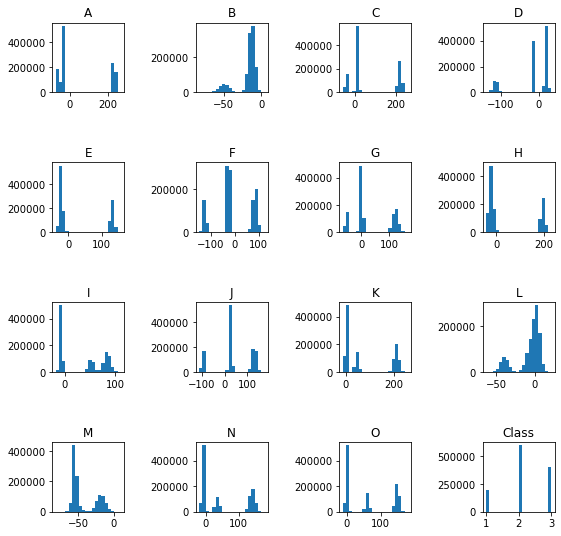

In [10]:
features = 'ABCDEFGHIJKLMNO'
fig_corr = plt.figure()
for i in range(1,16):
    fig_corr.add_subplot(4,4,i)
    plt.hist(df[features[i-1:i]], bins=20)
    plt.title(features[i-1:i])
fig_corr.add_subplot(4,4,16)
plt.hist(df['Class'], bins=20)
plt.title('Class')
fig_corr.subplots_adjust(hspace=1, wspace=1)
fig_corr.set_figheight(9)
fig_corr.set_figwidth(9)

Both, the statistics of correlation and this visualization of information now allows us to check the grouping of similar features in this data.

Following are the groups:
- A,C,E,F,G,H,I,J,K,M,N,O
- D,L
- B

Infact, there is also a correlation between B <-> D and merging the two groups into B,D,L. And also B <-> J making all the features into one group. Although these correlations have a value of less than 0.90 and thus we don't consider them to get three groups.

Next we will make a box plot to see the behaviour of our features.

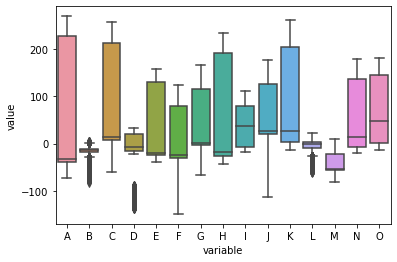

In [11]:
sns.boxplot(x="variable", y="value", data=pd.melt(df.iloc[:,:15]))
plt.show()

Boxplot shows that group B, D, L have potential outliers. We all see that some features have higher spread and even negative median values. This is cross-verified with our groups, as we have grouped B separately from other groups. A shows the highest spread, and can be used as a important feature later on.

___
## Model Building

In this section we will be trying to create pipelines with different selected features, models and specific classes to understand which features to use. 

First we try to create a model with Decision Tree Classifier and brute force our groups to check for the features and their prediction accuracy.

### Brute Force over Feature pairs from the two groups with Decision Tree Classifier.

Since we have brought down the features to 3 groups, we can brute force over the data with trying combinations from the features in these 3 groups. This is not as complicated now and thus we will implement brute force method. Since there are 1,2,12 features in each groups, total computations are 12 * 2 * 1 = 24.

We create a function that can bruteforce over the given groups by trying all combinations with a specific classifier. (By default Decision Tree Classifier is used).

In [12]:
def Brute_Force_Feature_Groups(df, classifier = DecisionTreeClassifier(max_depth=3)):
    g1 = ['A','C','E','F','G','H','I','J','K','M','N','O']
    g2 = ['D','L']

    print("\nBrute Forcing over the combinations of features from different feature groups with the classifier as -> ", classifier)
    
    for g1_ in g1:
        for g2_ in g2:

            # pipeline
            to_keep = [g1_,g2_,'B','Class']
            X_train, X_test, y_train, y_test = splitter(df[to_keep])
            print('\n\n',to_keep[:-1])
            pipeline = PMMLPipeline([
                ('mapper',
                 DataFrameMapper([
                     (X_train.columns.values,StandardScaler())])),
                ('pca',
                 PCA(n_components=2)), 
                ('classifier', classifier
                 )
            ])

            # fit
            pipeline.fit(X_train,y_train.values.ravel());

            # predict
            prediction = pipeline.predict(X_test)
            print('Accuracy = ',metrics.accuracy_score(y_test.values.ravel(),prediction))

            # print statistics
            class_and_counts = np.unique(np.array(prediction), return_counts=True)
            print("\nClass -> Count")
            print(class_and_counts[0],'->',class_and_counts[1])
            y_test_np = y_test.to_numpy()
            y_test_np.reshape(1,y_test_np.shape[0])
            TF_count = np.unique(prediction[0] == y_test_np, return_counts=True)
            print("\nTruth Count")
            print(TF_count[0], '->', TF_count[1])
            print("____________________________________")

In [13]:
Brute_Force_Feature_Groups(df)


Brute Forcing over the combinations of features from different feature groups with the classifier as ->  DecisionTreeClassifier(max_depth=3)


 ['A', 'D', 'B']
Accuracy =  0.49928333333333336

Class -> Count
[2 3] -> [239999      1]

Truth Count
[False  True] -> [120172 119828]
____________________________________


 ['A', 'L', 'B']
Accuracy =  0.499475

Class -> Count
[2 3] -> [239954     46]

Truth Count
[False  True] -> [120114 119886]
____________________________________


 ['C', 'D', 'B']
Accuracy =  0.498325

Class -> Count
[1 2 3] -> [     2 239990      8]

Truth Count
[False  True] -> [120395 119605]
____________________________________


 ['C', 'L', 'B']
Accuracy =  0.49909166666666666

Class -> Count
[2 3] -> [239999      1]

Truth Count
[False  True] -> [120218 119782]
____________________________________


 ['E', 'D', 'B']
Accuracy =  0.49894166666666667

Class -> Count
[1 2 3] -> [     4 239987      9]

Truth Count
[False  True] -> [120251 119749]
________________________

We can see that we get a very random behaviour over all the combinations of the features from the two groups. This brute force gives us the unique predictions of the classes that the model gives as output. One other thing that is observed is that all the models give 2,3 class as output; rather majority of the predictions are of class 2 and very few times class 3 is predicted. This behaviour of the model is unknown and thus next we will try to brute force over the Classification Models.

### Brute Force over Classification models with features A, D and B from different groups.

Since we have reduced down selecting just 3 features from different feature groups, we can now perform bruteforce method.

We create a brute force function which implements the model with different classifiers on the df passed onto the function. (By default uses the features A,D and B).

In [14]:
def Brute_Force_Classifiers(df, keep = None):
    classifiers = [DecisionTreeClassifier(max_depth = 3),SVC(), RandomForestClassifier(max_depth = 3), KNeighborsClassifier(), xgb.XGBClassifier(random_state=1,learning_rate=0.01), SGDClassifier(alpha=0.001, max_iter=100)]

    if keep == None:
        to_keep = ['A','D','B']
    else:
        to_keep = keep
    to_keep.append('Class')
    
    print("\nBrute Forcing Classifiers over the features -> ", to_keep[:-1],"\n____________________________________")
    
    for classifier in classifiers:
        print('\n',classifier)

        # Fit on Model    
        X_train, X_test, y_train, y_test = splitter(df[to_keep])
        pipeline = PMMLPipeline([
            ('mapper',
             DataFrameMapper([
                 (X_train.columns.values,StandardScaler())])),
            ('pca',
             PCA(n_components=2)),
            ('classifier', DecisionTreeClassifier(max_depth=3)
             )
        ])

        # fit
        pipeline.fit(X_train,y_train.values.ravel());

        # predict
        prediction = pipeline.predict(X_test)
        print('Accuracy = ',metrics.accuracy_score(y_test.values.ravel(),prediction))

        # print statistics
        class_and_counts = np.unique(np.array(prediction), return_counts=True)
        print("\nClass -> Count")
        print(class_and_counts[0],'->',class_and_counts[1])
        y_test_np = y_test.to_numpy()
        y_test_np.reshape(1,y_test_np.shape[0])
        TF_count = np.unique(prediction[0] == y_test_np, return_counts=True)
        print("\nTruth Count")
        print(TF_count[0], '->', TF_count[1])
        print("____________________________________")

In [15]:
Brute_Force_Classifiers(df)


Brute Forcing Classifiers over the features ->  ['A', 'D', 'B'] 
____________________________________

 DecisionTreeClassifier(max_depth=3)
Accuracy =  0.49925

Class -> Count
[2 3] -> [239983     17]

Truth Count
[False  True] -> [120177 119823]
____________________________________

 SVC()
Accuracy =  0.49883333333333335

Class -> Count
[2 3] -> [239990     10]

Truth Count
[False  True] -> [120277 119723]
____________________________________

 RandomForestClassifier(max_depth=3)
Accuracy =  0.49885

Class -> Count
[2 3] -> [239976     24]

Truth Count
[False  True] -> [120276 119724]
____________________________________

 KNeighborsClassifier()
Accuracy =  0.4996291666666667

Class -> Count
[2 3] -> [239992      8]

Truth Count
[False  True] -> [120091 119909]
____________________________________

 XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='ga

It is observed from the above that running different Classifiers on the data doesn't improve the accuracy either. Infact even the predicted class labels are majorly from class 2 as before. Thus next we will try to train the model on isolated training data from pairs of 2 classes.

We do this to understand the accuracy we can get on the data of these pair of classes so that we can utilize this to build a final model.

### Brute Force model selection over pairs of class data.

Create DataFrame wrt pairs of classes. Also check the size of each class label.

In [16]:
df_cls1 = df[df['Class'] == 1 ]
print("Total Records from Lable 1 -> ",df_cls1.shape[0])

df_cls2 = df[df['Class'] == 2 ]
print("Total Records from Lable 2 -> ",df_cls2.shape[0])

df_cls3 = df[df['Class'] == 3 ]
print("Total Records from Lable 3 -> ",df_cls3.shape[0])

df_cls12 = pd.concat([df_cls1,df_cls2])
print("\nTotal Records from Lable 1 & 2 -> ",df_cls12.shape[0])
print("Percent of Class 1 in (1 & 2) - >", df_cls1.shape[0] / df_cls12.shape[0] * 100)
print("Percent of Class 2 in (1 & 2) - >", df_cls2.shape[0] / df_cls12.shape[0] * 100)

df_cls23 = pd.concat([df_cls2,df_cls3])
print("\nTotal Records from Lable 2 & 3 -> ",df_cls23.shape[0])
print("Percent of Class 2 in (2 & 3) - >", df_cls2.shape[0] / df_cls23.shape[0] * 100)
print("Percent of Class 3 in (2 & 3) - >", df_cls3.shape[0] / df_cls23.shape[0] * 100)

df_cls13 = pd.concat([df_cls1,df_cls3])
print("\nTotal Records from Lable 1 & 3 -> ",df_cls13.shape[0])
print("Percent of Class 1 in (1 & 3) - >", df_cls1.shape[0] / df_cls13.shape[0] * 100)
print("Percent of Class 3 in (1 & 3) - >", df_cls3.shape[0] / df_cls13.shape[0] * 100)

Total Records from Lable 1 ->  199992
Total Records from Lable 2 ->  599228
Total Records from Lable 3 ->  400780

Total Records from Lable 1 & 2 ->  799220
Percent of Class 1 in (1 & 2) - > 25.023397812867547
Percent of Class 2 in (1 & 2) - > 74.97660218713246

Total Records from Lable 2 & 3 ->  1000008
Percent of Class 2 in (2 & 3) - > 59.922320621435034
Percent of Class 3 in (2 & 3) - > 40.07767937856497

Total Records from Lable 1 & 3 ->  600772
Percent of Class 1 in (1 & 3) - > 33.289167937254064
Percent of Class 3 in (1 & 3) - > 66.71083206274592


##### Brute Force of Models over the DataFrame for classes 1 & 2:

In [17]:
Brute_Force_Classifiers(df_cls12)


Brute Forcing Classifiers over the features ->  ['A', 'D', 'B'] 
____________________________________

 DecisionTreeClassifier(max_depth=3)
Accuracy =  0.7503941342809239

Class -> Count
[2] -> [159844]

Truth Count
[False  True] -> [ 39898 119946]
____________________________________

 SVC()
Accuracy =  0.7506756587672981

Class -> Count
[2] -> [159844]

Truth Count
[False  True] -> [ 39853 119991]
____________________________________

 RandomForestClassifier(max_depth=3)
Accuracy =  0.7502940366857687

Class -> Count
[2] -> [159844]

Truth Count
[False  True] -> [ 39914 119930]
____________________________________

 KNeighborsClassifier()
Accuracy =  0.7494932559245264

Class -> Count
[1 2] -> [     6 159838]

Truth Count
[False  True] -> [ 40042 119802]
____________________________________

 XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', i

Taking just the data for the class 1 and 2 gives us an accuracy of approx 75%. But closly looking at the True-False rate and the output labels, it can be seen that the most predictions are from class label 2 and since the data has 75% records from class label 2, we are getting a false accuracy of 75%.

##### Brute Force of Models over the DataFrame for classes 2 & 3:

In [18]:
Brute_Force_Classifiers(df_cls23)


Brute Forcing Classifiers over the features ->  ['A', 'D', 'B'] 
____________________________________

 DecisionTreeClassifier(max_depth=3)
Accuracy =  0.5973890261097389

Class -> Count
[2 3] -> [199972     30]

Truth Count
[False  True] -> [ 80513 119489]
____________________________________

 SVC()
Accuracy =  0.6026289737102629

Class -> Count
[2 3] -> [199985     17]

Truth Count
[False  True] -> [ 79470 120532]
____________________________________

 RandomForestClassifier(max_depth=3)
Accuracy =  0.5994390056099439

Class -> Count
[2 3] -> [199985     17]

Truth Count
[False  True] -> [ 80112 119890]
____________________________________

 KNeighborsClassifier()
Accuracy =  0.5993590064099359

Class -> Count
[2 3] -> [200001      1]

Truth Count
[False  True] -> [ 80128 119874]
____________________________________

 XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None

Taking just the data for the class 2 and 3 gives us an accuracy of approx 60%. But closly looking at the True-False rate and the output labels, it can be seen that the most predictions are again from class label 2 and since the data has 60% records from class label 2, we are getting a false accuracy of 60%.

##### Brute Force of Models over the DataFrame for classes 1 & 3:

In [19]:
Brute_Force_Classifiers(df_cls13)


Brute Forcing Classifiers over the features ->  ['A', 'D', 'B'] 
____________________________________

 DecisionTreeClassifier(max_depth=3)
Accuracy =  0.6664225375556573

Class -> Count
[1 3] -> [     6 120149]

Truth Count
[False  True] -> [40079 80076]
____________________________________

 SVC()
Accuracy =  0.6666971828055428

Class -> Count
[3] -> [120155]

Truth Count
[False  True] -> [40048 80107]
____________________________________

 RandomForestClassifier(max_depth=3)
Accuracy =  0.6653489243061046

Class -> Count
[1 3] -> [    16 120139]

Truth Count
[False  True] -> [40208 79947]
____________________________________

 KNeighborsClassifier()
Accuracy =  0.6674462153052307

Class -> Count
[1 3] -> [    23 120132]

Truth Count
[False  True] -> [39953 80202]
____________________________________

 XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type

Taking just the data for the class 1 and 3 gives us an accuracy of approx 66%. But closly looking at the True-False rate and the output labels, it can be seen that the most predictions are again from class label 3 and since the data has 66% records from class label 3, we are getting a false accuracy of 66%.

___
## Important Findings

It can be observed that the models we are getting are bias towards the class 2, which has the highest records. Then class 3, which has the second highest records and finally class 1 is getting the least priority in the models.

Thus there is a need to make our sample balanced. To do so we will under sample our model so that each class can be predicted equally.

_This might not give us a better accuracy, but will surely increase the number of class 1 and 3 predictions_

In [123]:
df_cls2 = df_cls2.sample(n = df_cls1.shape[0])
df_cls3 = df_cls3.sample(n = df_cls1.shape[0])
frames = [df_cls1, df_cls2, df_cls3]
df_new = pd.concat(frames)

This gives us a new Dataframe over which we will fit our final pipeline which we will define in our next section.

___
## Final Model

For our final model, we will be preprocessing the data using Standard Scalar to get the data scaled. Then we will be using PCA value of 3 as that gives us a total of approx 95% variance coverage. Then we will use the 'SelectKBest' feature selector with a hyperparameter of 3 as there are two prominant groups of features in our data. Then finally, as Classifier we will be using Decision Tree Classifier with a max depth of 2.

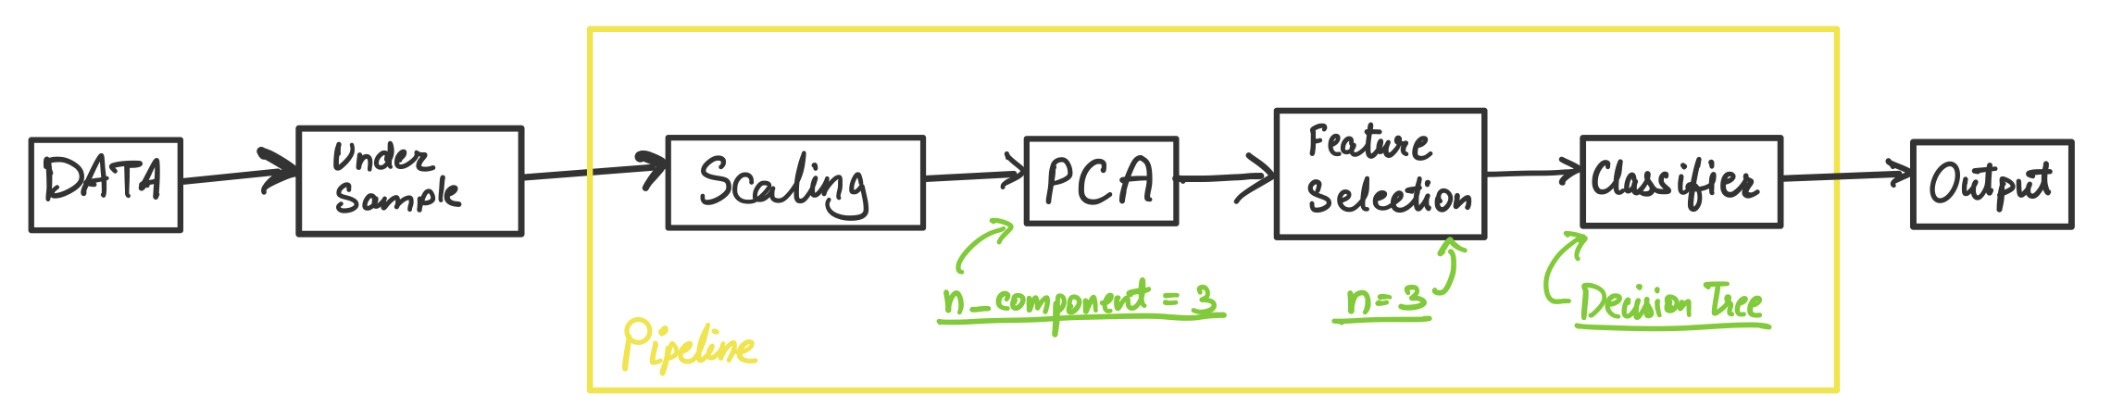

In [133]:
# Fit on Model    
X_train, X_test, y_train, y_test = splitter(df_new)
pipeline = PMMLPipeline([
    ('mapper',
     DataFrameMapper([
         (X_train.columns.values,StandardScaler())])),
    ('pca',
     PCA(n_components=3)),
    ('feature_selection', SelectKBest(k=3)),
    ('classifier', DecisionTreeClassifier(max_depth=3)
     )
])

# fit
pipeline.fit(X_train,y_train.values.ravel());

# predict
prediction = pipeline.predict(X_test)
print('Accuracy = ',metrics.accuracy_score(y_test.values.ravel(),prediction))

# print statistics
class_and_counts = np.unique(np.array(prediction), return_counts=True)
print("\nClass -> Count")
print(class_and_counts[0],'->',class_and_counts[1])
y_test_np = y_test.to_numpy()
y_test_np.reshape(1,y_test_np.shape[0])
TF_count = np.unique(prediction[0] == y_test_np, return_counts=True)
print("\nTruth Count")
print(TF_count[0], '->', TF_count[1])
print("____________________________________")

Accuracy =  0.33374445814860493

Class -> Count
[1 2 3] -> [ 1246 26859 91891]

Truth Count
[False  True] -> [79808 40188]
____________________________________


We can see that this new model with the preprocessed data gives predictions for all three class labels. This is exactly what we trying to achieve, although the accuracy has dropped. This is due to the fact that the data is bias, bad data! We tried every combination of the feature groups and also tried different classifiers. But even after getting a balanced data from all the labels, there is no relation that can be drawn out of the data. Thus we continue with this model.

___
## ONNX PIPELINE

We now make a Pipeline in Onnx for our selected model.

In [134]:
transformer = Pipeline(steps=[
    ('scaler',
     StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('feature',
     transformer,
     df_new.columns[:15])
])

classifier = DecisionTreeClassifier(max_depth=3)

In [135]:
pipeline_onnx = Pipeline([
    ('precprocessor',
     preprocessor),
    ('pca',
     PCA(n_components=3)),
    ('selector',
     SelectKBest(k=3)),
    ('classifier',
     classifier)
])

pipeline_onnx.fit(X_train,y_train);
print(classification_report(pipeline_onnx.predict(X_train),y_train))

              precision    recall  f1-score   support

           1       0.01      0.36      0.02      4864
           2       0.23      0.34      0.27    108306
           3       0.77      0.33      0.47    366810

    accuracy                           0.34    479980
   macro avg       0.34      0.34      0.25    479980
weighted avg       0.64      0.34      0.42    479980



In [136]:
input_types = dict([(x, FloatTensorType([None, 1])) for x in X_train.columns.values])

try:
    model_onnx = convert_sklearn(pipeline_onnx,
                                 'pipeline_onnx',
                                initial_types=list(input_types.items()))
except Exception as e:
    print(e)

with open("./pipeline/pipeline.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

In [137]:
inputs_onnx = {k: np.array(v).astype(np.float32)[:, np.newaxis] for k, v in X_test.to_dict(orient='list').items()}

session_onnx = rt.InferenceSession("./pipeline/pipeline.onnx")
predict_onnx = session_onnx.run(None, inputs_onnx)
print("predict", predict_onnx[0])

predict [2 3 3 ... 3 3 3]


In [138]:
# print statistics
class_and_counts = np.unique(predict_onnx[0], return_counts=True)
print("\nClass -> Count")
print(class_and_counts[0],'->',class_and_counts[1])
print("\nTruth Count")
y_test = y_test.to_numpy().reshape(1,-1)
TF_count = np.unique(predict_onnx[0] == y_test, return_counts=True)
print(TF_count[0],'->',TF_count[1])


Class -> Count
[1 2 3] -> [ 1246 26860 91890]

Truth Count
[False  True] -> [79948 40048]


___
## Conclusion: 

- It is observed that even after doing most possible methods, it is not possible to get an accurate model for some types of data. This is due to the bad data relations as well as biases in the data.
- We even brute forced through all the feature groups and classified, though we couldn't find a cood combination to solve our problem.
- Data is multimodal with few outliers.
- Data needs to preprocessed with standard scalar i.e. needs to be scaled. Scaling and transformation improves the accuracy.
- Additionally the data needs to be balanced as class label 2 records are way more. Balancing the class labels by under sampling will give better models.
- Optimal Dimensionality is 2 as PCA covers a total of 95%+ variance in the first two dimensions.
- This is a mutliclass classification problem and models which are better in multiclassification improve accuracy.
- Segregating data on basis of groups of class and using classfiers improve accuracy and provide better estimate. But this is a sudo improvement as the models only predict class 2 unless they are preprossed with under-sampling.
- Results of feature engineering at a certain extent are inconclusive, even with pairs of classes. This is due to the high covariance of the data. Thus we need to keep just features unique from each feature groups.
- Using of Pipeline can save time and streamine process.
- Using subset of optimum features can improve model.

____
## References

Links I drew specific code or packages from are in-line above.
Other links:
- Notebook: Individual Project - Pipeline - ONNX - Example.ipynb
- Notebook: Individual Project - Pipeline - PMML - Example.ipynb
- Example: Example Project - Spring 2019 - Victoria Belotti.pdf
- https://machinelearningmastery.com/k-fold-cross-validation/#
- https://elitedatascience.com/python-machine-learning-tutorial-scikit-learn#step-7
- https://stats.stackexchange.com/questions/111968/random-forest-how-to-handle-overfitting
- https://chrisalbon.com/machine_learning/model_evaluation/cross_validation_pipeline/
- https://www.datascience.com/blog/machine-learning-generalization